# IBM Data Science Capstone Project

This notebook will guide you through a theoretical business problem. The question that we are trying to answer is the following:
A successful owner of multiple mid-high-end restaurants decided to open a new restaurant in Budapest, Hungary. Having visited the city many times in the recent years, he couldn't disregard the big boom in gastronomy in the city. He is keen on opening a new unit which will focus on the European and Asian fusion kitchen. 

Taking into account the price level that the restaurant will operate, the intent is to find an optimal place in an area, where gastronomy is booming and easily accessible for tourists and for wealthier local citizens as well.

Assumptions, business logic:
The assumption behind the analysis is that we can use unsupervised machine learning to create clusters of districts that will provide us a list of areas for consideration for the restaurant. The intent is that the restaurant to be situated close one of the gastronomical centers.

To do this, we will need the following data:
1. List of the districts of Budapest -> this comes from a csv list
2. Geo-coordinates of the districts in Budapest -> this is obtained via geocoder
3. Top venues of districts -> Foursquare API is used to collect the venue data

Methodology:
After tidying up the data, we will apply K-means machine learning technique for creating clusters of districts. We will use silhouette score for choosing the optimal number of clusters.

Limitations:
The analysis has some limitations that should be taken into account. Some limitations:
1. The analysis is performed on 17 of the 23 districts in Budapest. That is due to technical limitations with geocoder.
2. The analsiss is performed on a district level.
3. When collecting venues a 1000 meter radius is used around the center coordinates of the districts. The number of collected venues is limited to 100 per districts.




### Importing libraries

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library


print('Libraries imported.')

# 1. Putting the Data together

## Budapest Districts

We get the list of districts from a csv file. There are 23 districts in Budapest and they are numbered, and not all of them have a name.

In [ ]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f0191162a61f4e778e2ebaf1b7b67c78 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='SsXmnm5GYcfnJffcHv8wPDRVt6ArIfUS3ryz8vbZRyNF',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_f0191162a61f4e778e2ebaf1b7b67c78.get_object(Bucket='ibmdatasciencecapstoneproject-donotdelete-pr-z9ey3hktshqiky',Key='budapest_districts.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body, sep=';')
df_data_1.head()


In [ ]:
df_data_1.shape

Creating the dataframe which will contain latitude and longitude data

In [161]:
# define the dataframe columns
column_names = ['District', 'Name', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighbors = pd.DataFrame(columns=column_names)

neighbors

,District,Name,Latitude,Longitude


Getting the geo-coordinates for the districts

In [162]:

district = df_data_1['District']
name = df_data_1['Name']
location = None
latitude = None
longitude = None

for data in range(0, len(district)):
    dt = district[data]
    nm = name[data]
    
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode('{}'.format(dt))
    latitude = location.latitude
    longitude = location.longitude

    neighbors = neighbors.append({ 'District':dt,'Name':nm,'Latitude': location.latitude,'Longitude': location.longitude}, ignore_index=True)
    
    

GeocoderUnavailable: Service not available

In [163]:
neighbors

,District,Name,Latitude,Longitude
0,I. kerület,"Várkerület (""Castle District"")",47.496994,19.034263
1,II. kerület,-,47.542471,18.972903
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",47.568691,19.027668
3,IV. kerület,"Újpest (""New Pest"")",47.577779,19.093164
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",47.500336,19.048971
5,VI. kerület,"Terézváros (""Theresa Town"")",47.508077,19.064426
6,VII. kerület,"Erzsébetváros (""Elisabeth Town"")",47.502627,19.077243
7,VIII. kerület,"Józsefváros (""Joseph Town"")",47.488755,19.086433
8,IX. kerület,"Ferencváros (""Francis Town"")",47.465070,19.096752
9,X. kerület,"Kőbánya (""Quarry"")",47.482405,19.158975


In [164]:
neighbors.shape

(17, 4)

As you can notice, we have only 17 districts here and that is due to the error with geocode that failed to retrieve the whole list. I have tried several times, but eventually I decided to proceed with the data I have. Nevertheless, the higher number of districts are mainly outskirts and very unlikely to have a material impact on the analysis.

### Mapping Budapest with the 17 districts

First, let's find the geodata for Budapest

In [217]:
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode('Budapest')
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinate of Budapest are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Budapest are 47.48138955, 19.14607278448202.


Let's create a map, with showing the districts

In [168]:
map_budapest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(neighbors['Latitude'], neighbors['Longitude'], neighbors['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

# 2. Exploring the Districts

## Exploring Top District Venues with Foursquare

Foursquare credentials

In [3]:
CLIENT_ID = '5ZN1PMFBHE1JD0V0STPPDUPF551Q5RK15DEU1I1QI5QDUJBV' #  Foursquare ID
CLIENT_SECRET = 'T4DLPCIRTHY0WNXCNRHNIKQ44GQJVIG4UPEFYT2XO1UXZS5I' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ZN1PMFBHE1JD0V0STPPDUPF551Q5RK15DEU1I1QI5QDUJBV
CLIENT_SECRET:T4DLPCIRTHY0WNXCNRHNIKQ44GQJVIG4UPEFYT2XO1UXZS5I


## Exploring the first District

District is called 'kerület' in Hungarian

In [170]:
neighbors.loc[0, 'District']

'I. kerület'

Getting the district's geo coordinates

In [171]:
neighborhood_latitude = neighbors.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighbors.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighbors.loc[0, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Várkerület ("Castle District") are 47.4969935, 19.034263015810748.


Getting the top 100 venues that are in I. kerulet (First district) within a radius of 1000 meters.
This will be obtained from Foursquare.

In [172]:
search_query = 'venues'
radius = 1000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?&client_id=5ZN1PMFBHE1JD0V0STPPDUPF551Q5RK15DEU1I1QI5QDUJBV&client_secret=T4DLPCIRTHY0WNXCNRHNIKQ44GQJVIG4UPEFYT2XO1UXZS5I&v=20180605&ll=47.4969935,19.034263015810748&radius=1000&limit=100'

Getting the json of venues

In [173]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e6273bf0be7b40029edfc94'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Budavári Palota',
  'headerFullLocation': 'Budavári Palota, Budapest',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 165,
  'suggestedBounds': {'ne': {'lat': 47.505993509000014,
    'lng': 19.047559079718177},
   'sw': {'lat': 47.48799349099999, 'lng': 19.02096695190332}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5dceff35f1c28a0008a4e570',
       'name': 'Stand25 Bisztró',
       'location': {'address': 'Attila út 10.',
        'lat': 47.497673,
        'lng': 19.032679,
        'labeledLatLngs': [{'label': 'display',
          'lat': 47.497673,

Defining a function to get categories

In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Tidying up the data 

In [174]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Stand25 Bisztró,5dceff35f1c28a0008a4e570,Bistro,47.497673,19.032679
1,Tabán Kinotéka,4c1d0c29b4e62d7f150ddc93,Indie Movie Theater,47.495818,19.034303
2,Budavári Mikve,5adb36dee4c459213da14b2e,Historic Site,47.498546,19.035846
3,Szelence Café,5220759911d2356f5427383c,Café,47.497767,19.031901
4,Dísz tér,4d46bd852e326ea83a21faa6,Plaza,47.499100,19.036163
5,Déryné Bisztró,4c5fba3bb36eb713f8049ad2,Bistro,47.497269,19.031708
6,Chococo,4e9da5ddb6348df6f736a98d,Chocolate Shop,47.497567,19.032413
7,Sis & Bro Boutique Cafe,547da881498ec93875ba5abf,Coffee Shop,47.497763,19.031937
8,Budavári Palota,4bc9f998937ca59338c2a692,Castle,47.496198,19.039543
9,Honda Dream,4c948ab172dd224be9ed9a91,Motorcycle Shop,47.498561,19.031825


In [175]:
#fix the column names

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Stand25 Bisztró,5dceff35f1c28a0008a4e570,Bistro,47.497673,19.032679
1,Tabán Kinotéka,4c1d0c29b4e62d7f150ddc93,Indie Movie Theater,47.495818,19.034303
2,Budavári Mikve,5adb36dee4c459213da14b2e,Historic Site,47.498546,19.035846
3,Szelence Café,5220759911d2356f5427383c,Café,47.497767,19.031901
4,Dísz tér,4d46bd852e326ea83a21faa6,Plaza,47.499100,19.036163
5,Déryné Bisztró,4c5fba3bb36eb713f8049ad2,Bistro,47.497269,19.031708
6,Chococo,4e9da5ddb6348df6f736a98d,Chocolate Shop,47.497567,19.032413
7,Sis & Bro Boutique Cafe,547da881498ec93875ba5abf,Coffee Shop,47.497763,19.031937
8,Budavári Palota,4bc9f998937ca59338c2a692,Castle,47.496198,19.039543
9,Honda Dream,4c948ab172dd224be9ed9a91,Motorcycle Shop,47.498561,19.031825


## Now let's explore the other districts as well

for that, let's create a function

In [176]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Let's collect the data

In [178]:
budapest_venues = getNearbyVenues(names=neighbors['District'],
                                   latitudes=neighbors['Latitude'],
                                   longitudes=neighbors['Longitude']
                                  )

I. kerület
II. kerület
III. kerület
IV. kerület
V. kerület
VI. kerület
VII. kerület
VIII. kerület
IX. kerület
X. kerület
XI. kerület
XII. kerület
XIII. kerület
XIV. kerület
XV. kerület
XVI. kerület
XVII. kerület


In [179]:
print(budapest_venues.shape)
budapest_venues.head()

(928, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,I. kerület,47.496994,19.034263,Stand25 Bisztró,47.497673,19.032679,Bistro
1,I. kerület,47.496994,19.034263,Tabán Kinotéka,47.495818,19.034303,Indie Movie Theater
2,I. kerület,47.496994,19.034263,Budavári Mikve,47.498546,19.035846,Historic Site
3,I. kerület,47.496994,19.034263,Szelence Café,47.497767,19.031901,Café
4,I. kerület,47.496994,19.034263,Dísz tér,47.499100,19.036163,Plaza


Now, checking how many venues were collected for other districts as well. 

In [181]:
budapest_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
I. kerület,100,100,100,100,100,100
II. kerület,43,43,43,43,43,43
III. kerület,28,28,28,28,28,28
IV. kerület,39,39,39,39,39,39
IX. kerület,14,14,14,14,14,14
V. kerület,100,100,100,100,100,100
VI. kerület,100,100,100,100,100,100
VII. kerület,100,100,100,100,100,100
VIII. kerület,85,85,85,85,85,85


### Checking how many distinct venue categories we have

In [182]:
print('There are {} uniques categories.'.format(len(budapest_venues['Venue Category'].unique())))

There are 188 uniques categories.


# 3. Analyzing the Districts

For that, we use one hot encoding.

In [183]:
# one hot encoding
budapest_onehot = pd.get_dummies(budapest_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
budapest_onehot['Neighborhood'] = budapest_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [budapest_onehot.columns[-1]] + list(budapest_onehot.columns[:-1])
budapest_onehot = budapest_onehot[fixed_columns]

budapest_onehot.head()

,Yoga Studio,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Candy Store,Carpet Store,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Kids Store,Lebanese Restaurant,Light Rail Station,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Music Store,Music Venue,Neighborhood,Office,Opera House,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool Hall,Pub,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Ski Area,Smoke Shop,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I. kerület,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I. kerület,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I. kerület,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I. kerület,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [184]:
budapest_onehot.shape

(928, 188)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [185]:
budapest_grouped = budapest_onehot.groupby('Neighborhood').mean().reset_index()
budapest_grouped

,Neighborhood,Yoga Studio,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Candy Store,Carpet Store,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hockey Arena,Hockey Field,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Kids Store,Lebanese Restaurant,Light Rail Station,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Music Store,Music Venue,Office,Opera House,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool Hall,Pub,Record Shop,Rental Car Location,Rest Area,Restaurant,River,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Ski Area,Smoke Shop,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
0,I. kerület,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.030000,0.020000,0.01,0.000000,0.000000,0.000000,0.030000,0.01,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.070000,0.00,0.000000,0.01,0.000000,0.02,0.00,0.000000,0.00,0.050000,0.00,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.00,0.00,0.000000,0.00,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,0.00,0.040000,0.00,0.040000,0.00,0.010000,0.000000,0.01,0.000000,0.010000,0.00,0.00,0.00,0.000000,0.00,0.000,0.01,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.020000,0.01,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.050000,0.000000,0.060000,0.00,0.000000,0.000000,0.020000,0.000000,0.01,0.00,0.00,0.000000,0.040000,0.000000,0.000000,0.02,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.010000,0.000000,0.00,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### Let's see each neighborhood along with the top 5 most common venues

In [187]:
num_top_venues = 5

for hood in budapest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = budapest_grouped[budapest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----I. kerület----
         venue  freq
0         Café  0.07
1          Pub  0.06
2        Plaza  0.05
3         Park  0.05
4  Coffee Shop  0.05


----II. kerület----
           venue  freq
0  Grocery Store  0.12
1   Tram Station  0.07
2    Pizza Place  0.07
3     Smoke Shop  0.05
4           Park  0.05


----III. kerület----
           venue  freq
0       Bus Stop  0.18
1   Dessert Shop  0.07
2  Train Station  0.07
3  Grocery Store  0.07
4    Yoga Studio  0.04


----IV. kerület----
          venue  freq
0      Bus Stop  0.21
1  Soccer Field  0.10
2          Park  0.05
3    Playground  0.03
4  Burger Joint  0.03


----IX. kerület----
               venue  freq
0         Restaurant  0.21
1       Tram Station  0.14
2      Train Station  0.14
3        Bus Station  0.07
4  Electronics Store  0.07


----V. kerület----
                  venue  freq
0                 Hotel  0.11
1  Hungarian Restaurant  0.07
2            Restaurant  0.06
3    Italian Restaurant  0.04
4           Coffee Shop  

Putting it into a dataframe

In [188]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [189]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = budapest_grouped['Neighborhood']

for ind in np.arange(budapest_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(budapest_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I. kerület,Café,Pub,Park,Coffee Shop,Plaza,Historic Site,Hotel,Hungarian Restaurant,Scenic Lookout,Playground
1,II. kerület,Grocery Store,Pizza Place,Tram Station,Park,Smoke Shop,Bus Stop,Gym,Forest,History Museum,Shopping Mall
2,III. kerület,Bus Stop,Grocery Store,Train Station,Dessert Shop,Eastern European Restaurant,School,Clothing Store,Deli / Bodega,Department Store,Yoga Studio
3,IV. kerület,Bus Stop,Soccer Field,Park,Hotel,Food & Drink Shop,Burger Joint,Bus Station,Pharmacy,Café,Soccer Stadium
4,IX. kerület,Restaurant,Tram Station,Train Station,Bus Station,Electronics Store,Fast Food Restaurant,Soccer Field,Office,Furniture / Home Store,Department Store


##  Using Machine Learning for Clustering Neighborhoods

For clustering, K-means method will be applied. To be able to select the optimal number of clusters,  the silhouette score will be used.

First, let's find out the optimal number of clusters. For that, we will create a graph of the silhouette scores.

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [191]:
max_range = 8

budapest_grouped_clustering = budapest_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = budapest_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

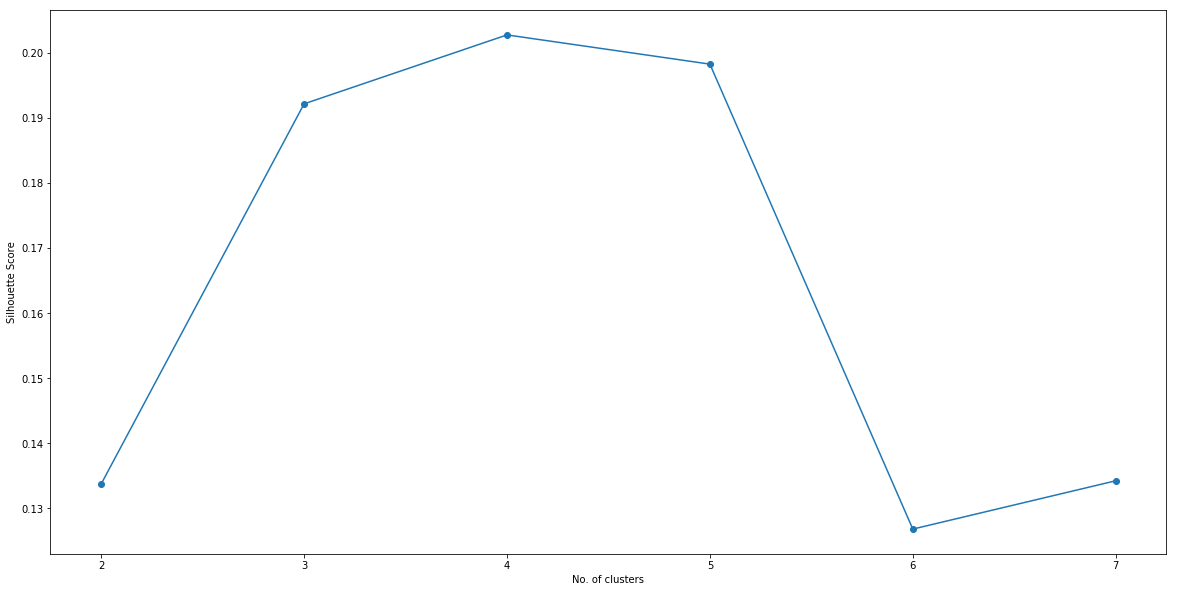

In [192]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Based on this graph, we can see that the optimal number of clusters is 4.

Now let's run the K-means clustering with the optimal number of clusters, which is 4.

In [199]:
# run k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(budapest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 2, 3, 1, 1, 1, 1, 1], dtype=int32)

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [200]:
neighbors.rename(columns={'District':'Neighborhood'}, inplace=True)
neighbors.head()

,Neighborhood,Name,Latitude,Longitude
0,I. kerület,"Várkerület (""Castle District"")",47.496994,19.034263
1,II. kerület,-,47.542471,18.972903
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",47.568691,19.027668
3,IV. kerület,"Újpest (""New Pest"")",47.577779,19.093164
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",47.500336,19.048971


In [203]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

budapest_merged = neighbors

# merge budapest_grouped with budapest_data to add latitude/longitude for each neighborhood
budapest_merged = budapest_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

budapest_merged

,Neighborhood,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I. kerület,"Várkerület (""Castle District"")",47.496994,19.034263,1,Café,Pub,Park,Coffee Shop,Plaza,Historic Site,Hotel,Hungarian Restaurant,Scenic Lookout,Playground
1,II. kerület,-,47.542471,18.972903,1,Grocery Store,Pizza Place,Tram Station,Park,Smoke Shop,Bus Stop,Gym,Forest,History Museum,Shopping Mall
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",47.568691,19.027668,2,Bus Stop,Grocery Store,Train Station,Dessert Shop,Eastern European Restaurant,School,Clothing Store,Deli / Bodega,Department Store,Yoga Studio
3,IV. kerület,"Újpest (""New Pest"")",47.577779,19.093164,2,Bus Stop,Soccer Field,Park,Hotel,Food & Drink Shop,Burger Joint,Bus Station,Pharmacy,Café,Soccer Stadium
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",47.500336,19.048971,1,Hotel,Hungarian Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Plaza,Modern European Restaurant,Salad Place,Dessert Shop,Sandwich Place
5,VI. kerület,"Terézváros (""Theresa Town"")",47.508077,19.064426,1,Coffee Shop,Pizza Place,Italian Restaurant,Thai Restaurant,Bar,Beer Bar,Theater,Indian Restaurant,Hungarian Restaurant,Bakery
6,VII. kerület,"Erzsébetváros (""Elisabeth Town"")",47.502627,19.077243,1,Hotel,Coffee Shop,Bar,Restaurant,Hungarian Restaurant,Beer Bar,Pizza Place,Gastropub,Burger Joint,Dessert Shop
7,VIII. kerület,"Józsefváros (""Joseph Town"")",47.488755,19.086433,1,Hotel,Park,Coffee Shop,Burger Joint,Chinese Restaurant,Bakery,Pub,Vietnamese Restaurant,Comedy Club,Bistro
8,IX. kerület,"Ferencváros (""Francis Town"")",47.465070,19.096752,3,Restaurant,Tram Station,Train Station,Bus Station,Electronics Store,Fast Food Restaurant,Soccer Field,Office,Furniture / Home Store,Department Store
9,X. kerület,"Kőbánya (""Quarry"")",47.482405,19.158975,1,Tram Station,Bus Stop,Arts & Entertainment,Sporting Goods Shop,Brewery,Market,Fast Food Restaurant,Supermarket,Grocery Store,Gym


Now, visualizing the clusters

In [204]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(budapest_merged['Latitude'], budapest_merged['Longitude'], budapest_merged['Neighborhood'], budapest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

### Cluster 1

In [212]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 0, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,XV. kerület,Supermarket,Fast Food Restaurant,Toy / Game Store,Bus Stop,Gym,Rest Area,Clothing Store,Furniture / Home Store,Eastern European Restaurant,Food & Drink Shop


### Cluster 2

In [213]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 1, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I. kerület,Café,Pub,Park,Coffee Shop,Plaza,Historic Site,Hotel,Hungarian Restaurant,Scenic Lookout,Playground
1,II. kerület,Grocery Store,Pizza Place,Tram Station,Park,Smoke Shop,Bus Stop,Gym,Forest,History Museum,Shopping Mall
4,V. kerület,Hotel,Hungarian Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Plaza,Modern European Restaurant,Salad Place,Dessert Shop,Sandwich Place
5,VI. kerület,Coffee Shop,Pizza Place,Italian Restaurant,Thai Restaurant,Bar,Beer Bar,Theater,Indian Restaurant,Hungarian Restaurant,Bakery
6,VII. kerület,Hotel,Coffee Shop,Bar,Restaurant,Hungarian Restaurant,Beer Bar,Pizza Place,Gastropub,Burger Joint,Dessert Shop
7,VIII. kerület,Hotel,Park,Coffee Shop,Burger Joint,Chinese Restaurant,Bakery,Pub,Vietnamese Restaurant,Comedy Club,Bistro
9,X. kerület,Tram Station,Bus Stop,Arts & Entertainment,Sporting Goods Shop,Brewery,Market,Fast Food Restaurant,Supermarket,Grocery Store,Gym
10,XI. kerület,Bakery,Bus Stop,Platform,Bus Station,Dog Run,Gym,Smoke Shop,Pharmacy,Pub,Hungarian Restaurant
12,XIII. kerület,Coffee Shop,Pub,Park,Gym / Fitness Center,Grocery Store,Indian Restaurant,Chinese Restaurant,Electronics Store,Restaurant,Café
13,XIV. kerület,Bus Stop,Gym / Fitness Center,Gym,Grocery Store,Chinese Restaurant,Bakery,Café,Spa,Pharmacy,Pizza Place


### Cluster 3

In [214]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 2, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,III. kerület,Bus Stop,Grocery Store,Train Station,Dessert Shop,Eastern European Restaurant,School,Clothing Store,Deli / Bodega,Department Store,Yoga Studio
3,IV. kerület,Bus Stop,Soccer Field,Park,Hotel,Food & Drink Shop,Burger Joint,Bus Station,Pharmacy,Café,Soccer Stadium
11,XII. kerület,Bus Stop,Park,Playground,Trail,Platform,Bakery,Bus Station,Mountain,Food,Grocery Store
16,XVII. kerület,Bus Stop,Cosmetics Shop,Carpet Store,Supermarket,Grocery Store,Gym,Bakery,Pet Store,Dessert Shop,Restaurant


### Cluster 4

In [215]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 3, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,IX. kerület,Restaurant,Tram Station,Train Station,Bus Station,Electronics Store,Fast Food Restaurant,Soccer Field,Office,Furniture / Home Store,Department Store


# 4. Conclusion

### Understanding the Clusters

By looking at the cluster data, we can see that cluster 2 is the one that we are the most interested in. 

Cluster 0 is an outer district where top gastronomy is not really represented (supermarket and fast food are in the top).

Cluster 3 is districts where public travel rated at top, but behind that parks, playgrounds are also present. These are mainly areas with family houses where people live, but not really the vibrant, lively part of the city.

Cluster 4 contain only one district. Here we see restaurant at the top, but behind that it is about public transport. 

Cluster 2 is the biggest cluster, but this is where we see lot's of gastronomy related venues (coffee shop, pizza place, Thai restaurant, beer bar, pub, modern European restaurant, etc..).

Based on that, we can advise the restaurant owner to consider the districts from this cluster as the potential location for the new restaurant.